## 範例重點
### 學習在模型開始前檢查各個環節
1. 是否有 GPU 資源
2. 將前處理轉為函式，統一處理訓練、驗證與測試集
3. 將超參數變數化，易於重複使用函式、模型等

In [1]:
## 確認硬體資源 (如果你是在 Linux, 若是在 Windows, 請參考 https://blog.csdn.net/idwtwt/article/details/78017565)
!nvidia-smi

Tue Nov 24 22:05:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.81       Driver Version: 456.81       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1660   WDDM  | 00000000:26:00.0  On |                  N/A |
| 28%   43C    P8     7W / 120W |    343MiB /  6144MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

In [6]:
import numpy as np
np.shape(x_train)

(50000, 32, 32, 3)

In [7]:
# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [8]:
np.shape(x_train)

(50000, 3072)

In [9]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


In [11]:
## 超參數設定
LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = 256

In [12]:
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

In [13]:
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 2s 45us/step - loss: 1.9339 - accuracy: 0.3003 - val_loss: 1.7720 - val_accuracy: 0.3577
Epoch 2/20
50000/50000 [==============================] - 2s 38us/step - loss: 1.7110 - accuracy: 0.3885 - val_loss: 1.7033 - val_accuracy: 0.4004
Epoch 3/20
50000/50000 [==============================] - 2s 38us/step - loss: 1.6206 - accuracy: 0.4206 - val_loss: 1.5801 - val_accuracy: 0.4399
Epoch 4/20
50000/50000 [==============================] - 2s 39us/step - loss: 1.5429 - accuracy: 0.4515 - val_loss: 1.5298 - val_accuracy: 0.4591
Epoch 5/20
50000/50000 [==============================] - 2s 39us/step - loss: 1.5000 - accuracy: 0.4653 - val_loss: 1.5055 - val_accuracy: 0.4621
Epoch 6/20
50000/50000 [==============================] - 2s 39us/step - loss: 1.4601 - accuracy: 0.4791 - val_loss: 1.4609 - val_accuracy: 0.4795
Epoch 7/20
50000/50000 [==============================] - 2s 38us/st

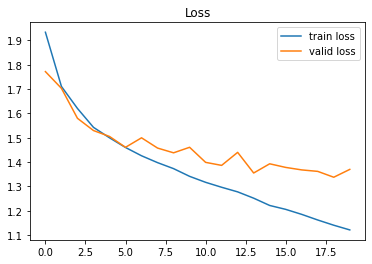

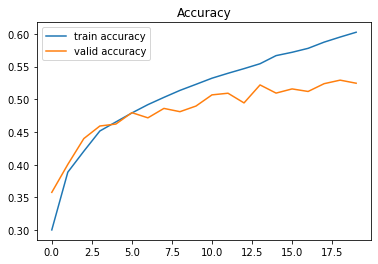

In [14]:
# 訓練模型並檢視驗證集的結果
import matplotlib.pyplot as plt

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]

train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

## Work
1. 請嘗試將 preproc_x 替換成以每筆資料的 min/max 進行標準化至 -1 ~ 1 間，再進行訓練
2. 請嘗試將 mlp 疊更深 (e.g 5~10 層)，進行訓練後觀察 learning curve 的走勢
3. (optional) 請改用 GPU 進行訓練 (如果你有 GPU 的話)，比較使用 CPU 與 GPU 的訓練速度